In [26]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import json

import datautils

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
num_classes = 11
feature_dim = datautils.FEATURE_DIM

In [4]:
print("Loading GloVe")
glove_dict = datautils.load_glove_dict()
print("Loading training data")
X_train, lens_train = datautils.load_train_examples(glove_dict)
y_train = datautils.load_train_labels()
print("Loading dev data")
X_val, lens_val = datautils.load_dev_examples(glove_dict)
y_val = datautils.load_dev_labels()

Loading GloVe
Loading training data
Loading dev data


In [5]:
print("X_train:", X_train.shape, X_train.dtype)
print("lens_train:", lens_train.shape, lens_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)

print("X_val:", X_val.shape, X_val.dtype)
print("lens_val:", lens_val.shape, lens_val.dtype)
print("y_val:", y_val.shape, y_val.dtype)

X_train: (11000, 212, 94) float32
lens_train: (11000,) int64
y_train: (11000,) int64
X_val: (1100, 211, 94) float32
lens_val: (1100,) int64
y_val: (1100,) int64


In [64]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, None, feature_dim])
y = tf.placeholder(tf.int64, [None])
lens = tf.placeholder(tf.int64, [None])

lr = 1e-2
dr = 0.0

learning_rate = tf.placeholder(tf.float32)
dropout = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool)

cell_size = 128
cell1 = tf.contrib.rnn.GRUCell(cell_size)
multicell = tf.contrib.rnn.MultiRNNCell(cells=[cell1])
outputs, states = tf.nn.dynamic_rnn(multicell, X, dtype=tf.float32, sequence_length=lens) # Outputs: N x L x W
#sampled_outputs = tf.reshape(outputs[:, 3:211:3], [-1, 70 * cell_size])

# TODO: figure out why some transcriptions have length 0
d1 = tf.layers.dropout(states[0], rate=dropout, training=is_training)
#regularizer = tf.contrib.layers.l2_regularizer(1e0)
y_out = tf.layers.dense(d1, num_classes)

#reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y, num_classes), logits=y_out))
optimizer = tf.train.AdamOptimizer(learning_rate)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [45]:
def run_model(session, predict, loss_val, Xd, yd, lensd,
              epochs=1, batch=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch))):
            # generate indicies for the batch
            start_idx = (i*batch)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch]
            
            # get batch size
            actual_batch_size = yd[i:i+batch].shape[0]

            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx],
                         y: yd[idx],
                         lens: lensd[idx],
                         is_training: training_now,
                         learning_rate: lr,
                         dropout: dr
                         }
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            iter_cnt += 1
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

In [65]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
run_data = []

In [ ]:
saver = tf.train.Saver()
saver.restore(sess, "gru-model-11")
with open("gru-model.txt") as logs:
    train_losses = [ float(val) for val in logs.readline().split() ]
    val_losses = [ float(val) for val in logs.readline().split() ]
    train_acc = [ float(val) for val in logs.readline().split() ]
    val_acc = [ float(val) for val in logs.readline().split() ]

Iteration 25: with minibatch training loss = 0.883 and accuracy of 0.7
Iteration 50: with minibatch training loss = 0.974 and accuracy of 0.61
Iteration 75: with minibatch training loss = 0.9 and accuracy of 0.67
Epoch 1, Overall loss = 0.981 and accuracy of 0.669


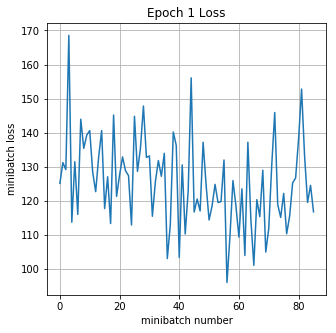

Epoch 1, Overall loss = 1.74 and accuracy of 0.417
Iteration 25: with minibatch training loss = 0.877 and accuracy of 0.7
Iteration 50: with minibatch training loss = 1.02 and accuracy of 0.67
Iteration 75: with minibatch training loss = 0.725 and accuracy of 0.77
Epoch 1, Overall loss = 0.867 and accuracy of 0.709


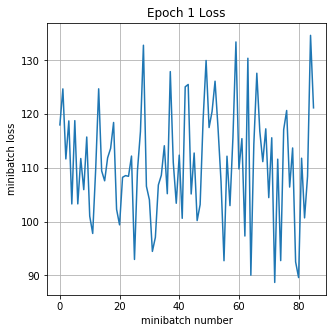

Epoch 1, Overall loss = 1.78 and accuracy of 0.425
Iteration 25: with minibatch training loss = 0.792 and accuracy of 0.74
Iteration 50: with minibatch training loss = 0.705 and accuracy of 0.77
Iteration 75: with minibatch training loss = 0.729 and accuracy of 0.77
Epoch 1, Overall loss = 0.79 and accuracy of 0.737


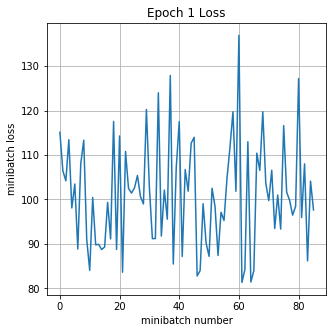

Epoch 1, Overall loss = 1.83 and accuracy of 0.414
Iteration 25: with minibatch training loss = 0.773 and accuracy of 0.76
Iteration 50: with minibatch training loss = 0.81 and accuracy of 0.77
Iteration 75: with minibatch training loss = 0.891 and accuracy of 0.72
Epoch 1, Overall loss = 0.722 and accuracy of 0.763


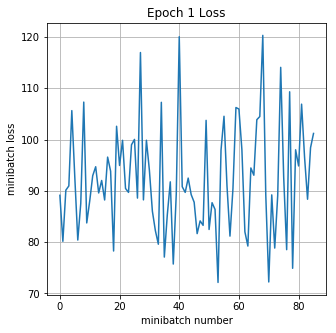

Epoch 1, Overall loss = 1.89 and accuracy of 0.414
Iteration 25: with minibatch training loss = 0.715 and accuracy of 0.76
Iteration 50: with minibatch training loss = 0.598 and accuracy of 0.81
Iteration 75: with minibatch training loss = 0.664 and accuracy of 0.78
Epoch 1, Overall loss = 0.657 and accuracy of 0.786


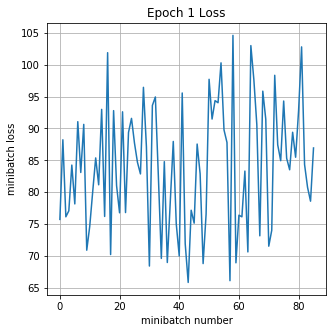

Epoch 1, Overall loss = 1.93 and accuracy of 0.417


In [68]:
epochs = 5
lr = 1e-3
dr = 0.0
for i in range(epochs):
    train_loss, train_acc = run_model(session=sess,
                          predict=y_out,
                          loss_val=mean_loss,
                          Xd=X_train,
                          yd=y_train,
                          lensd=lens_train,
                          epochs=1,
                          batch=128,
                          print_every=25,
                          training=train_step,
                          plot_losses=True)
    val_loss, val_acc = run_model(session=sess,
                          predict=y_out,
                          loss_val=mean_loss,
                          Xd=X_val,
                          yd=y_val,
                          lensd=lens_val,
                          epochs=1,
                          batch=X_val.shape[0],
                          print_every=1,
                          training=None,
                          plot_losses=False)
    run_dct = {"lr" : lr, "dr" : dr, "train_loss": train_loss, "train_acc": train_acc,
               "val_loss": val_loss, "val_acc" : val_acc}
    run_data.append(run_dct)

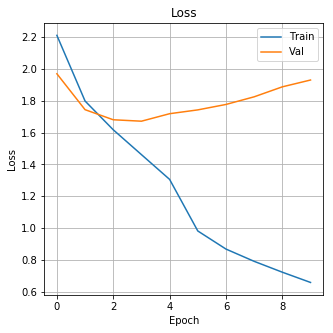

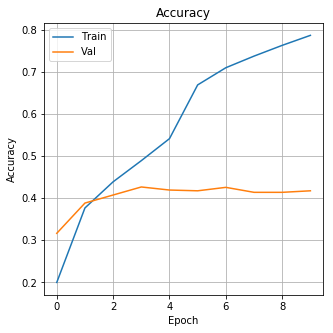

Max validation accuracy: 0.4263636363636364


In [69]:
plt.plot([ dct["train_loss"] for dct in run_data], label='Train')
plt.plot([ dct["val_loss"] for dct in run_data], label='Val')
plt.grid(True)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot([ dct["train_acc"] for dct in run_data], label='Train')
plt.plot([ dct["val_acc"] for dct in run_data], label='Val')
plt.grid(True)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("Max validation accuracy: {}".format(max([ dct["val_acc"] for dct in run_data])))

In [51]:
model_name = "gru-1-64-4"
saver = tf.train.Saver(max_to_keep=None)
saver.save(sess, "./checkpoints/" + model_name, global_step=len(run_data), latest_filename=model_name)

f = open("./checkpoints/{}.txt".format(model_name), 'w')
f.write(json.dumps(run_data))
f.close()

INFO:tensorflow:./checkpoints/gru-1-64-4-10 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:./checkpoints/gru-1-64-4-10 is not in all_model_checkpoint_paths. Manually adding it.
